<h2>Primer modelo</h2>

In [1]:
# To import util functions
import os
import sys
module_path = os.path.abspath(os.path.join('../util'))
if module_path not in sys.path:
    sys.path.append(module_path)

import datasetManager_FF as dM
import cleaner_FF as cl
import transformer_FF as tr
import modeler_FF as md

In [2]:
#Common libraries for work with data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy import stats


#Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Model libraries
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#Model training libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Metrics libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

#Other
import pickle

/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


<h3>Carga de datos (entrenamiento y validacion)</h3>

In [20]:
# Cargo el dataset
df = dM.cargar_datos(1)

In [21]:
# Limpia el dataset
cleaner = cl.Cleaner()
df = cleaner.clean_all(df)

In [22]:
# De manera ad hoc eliminamos los registros del dataset de entrenamiento con install_date > 382 
#porque vimos que el modelo performa mejor. Esto se debe a que para ese momento del tiempo no se creo el target = 1
# por no tener comportamiento sobre aquellos jugadores de forma precisa.
indexNames = df[df['install_date'] > 382 ].index
df.drop(indexNames , inplace=True)

In [23]:
# Transforma el dataset
transformer = tr.Transformer()
df = transformer.transform_all(df)

In [7]:
# Carga, limpia y transforma el dataset de validacion
validation = pd.read_csv('../datos/evaluation.csv')
validation = cleaner.clean_all(validation)
validation = transformer.transform_all(validation,df)

<h3>Modelado</h3>

In [8]:
modelador = md.Modeler()

In [31]:
# Separamos la variable target del resto de las features
features = df.loc[:, df.columns != 'Label']
labels = df.loc[:, df.columns == 'Label']

# Dividimos el dataset en test y train en un 10%. IMPORTANTE: siempre fijamos la semilla en 42 para poder replicar experimentos
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)


#tree_clf = RandomForestClassifier()

#tree_clf = XGBClassifier()

#tree_clf = LGBMClassifier()

# MEJOR MODELO ALCANZADO
tree_clf = LGBMClassifier(n_estimators = 1700, 
                       learning_rate = 0.12,
                       max_depth = 13, 
                       min_child_weight = 0.001,
                       colsample_bytree= 0.63,
                       metric='auc',
                       reg_lambda = 120,       # para regularizar error de tipo 1
                       reg_alpha = 35,         # para regularizar error de tipo 2
                       subsample= 1,
                       gamma = 5,
                       random_state=42)

#eval_set = [(X_test, y_test)]

#tree_clf.fit(X_train, y_train, early_stopping_rounds=40, eval_metric="auc", eval_set=eval_set, verbose=True)


tree_clf.fit(features, labels)


/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'\ntree_clf = RandomForestClassifier(max_depth=15, \n                                  min_samples_leaf=8, \n                                  min_samples_split=13,\n                                  random_state=42,\n                                  n_estimators= 100)\n\n'

<h3>Metricas de performance</h3>

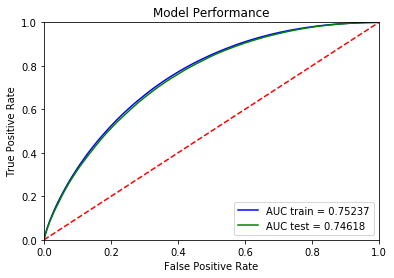

In [30]:
# Mejor LGBM alcanzado
modelador.plot_roc_2(tree_clf,X_train,y_train,X_test,y_test)

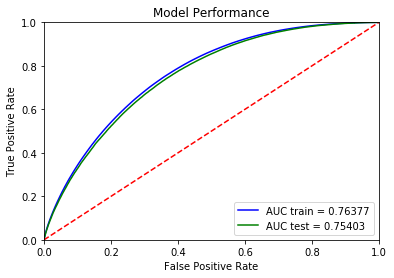

In [75]:
#XGBOOST pero en validation performa peor
modelador.plot_roc_2(tree_clf,X_train,y_train,X_test,y_test)

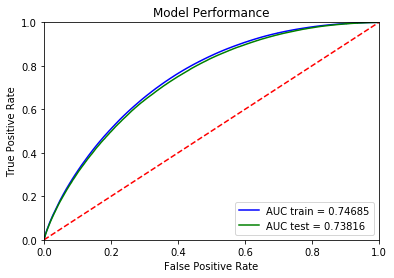

In [14]:
# Xgboost sin tunear
modelador.plot_roc_2(tree_clf,X_train,y_train,X_test,y_test)

In [10]:
# No esta ejecutado con el ultimo modelo
modelador.plot_confusion_matrix(tree_clf,X_train,y_train)

[[3117779    2881]
 [ 716783    5174]]


In [11]:
# No esta ejecutado con el ultimo modelo
modelador.plot_confusion_matrix(tree_clf,X_test,y_test)

[[1336090    1349]
 [ 307481    1916]]


<h4>Feature importance</h4>

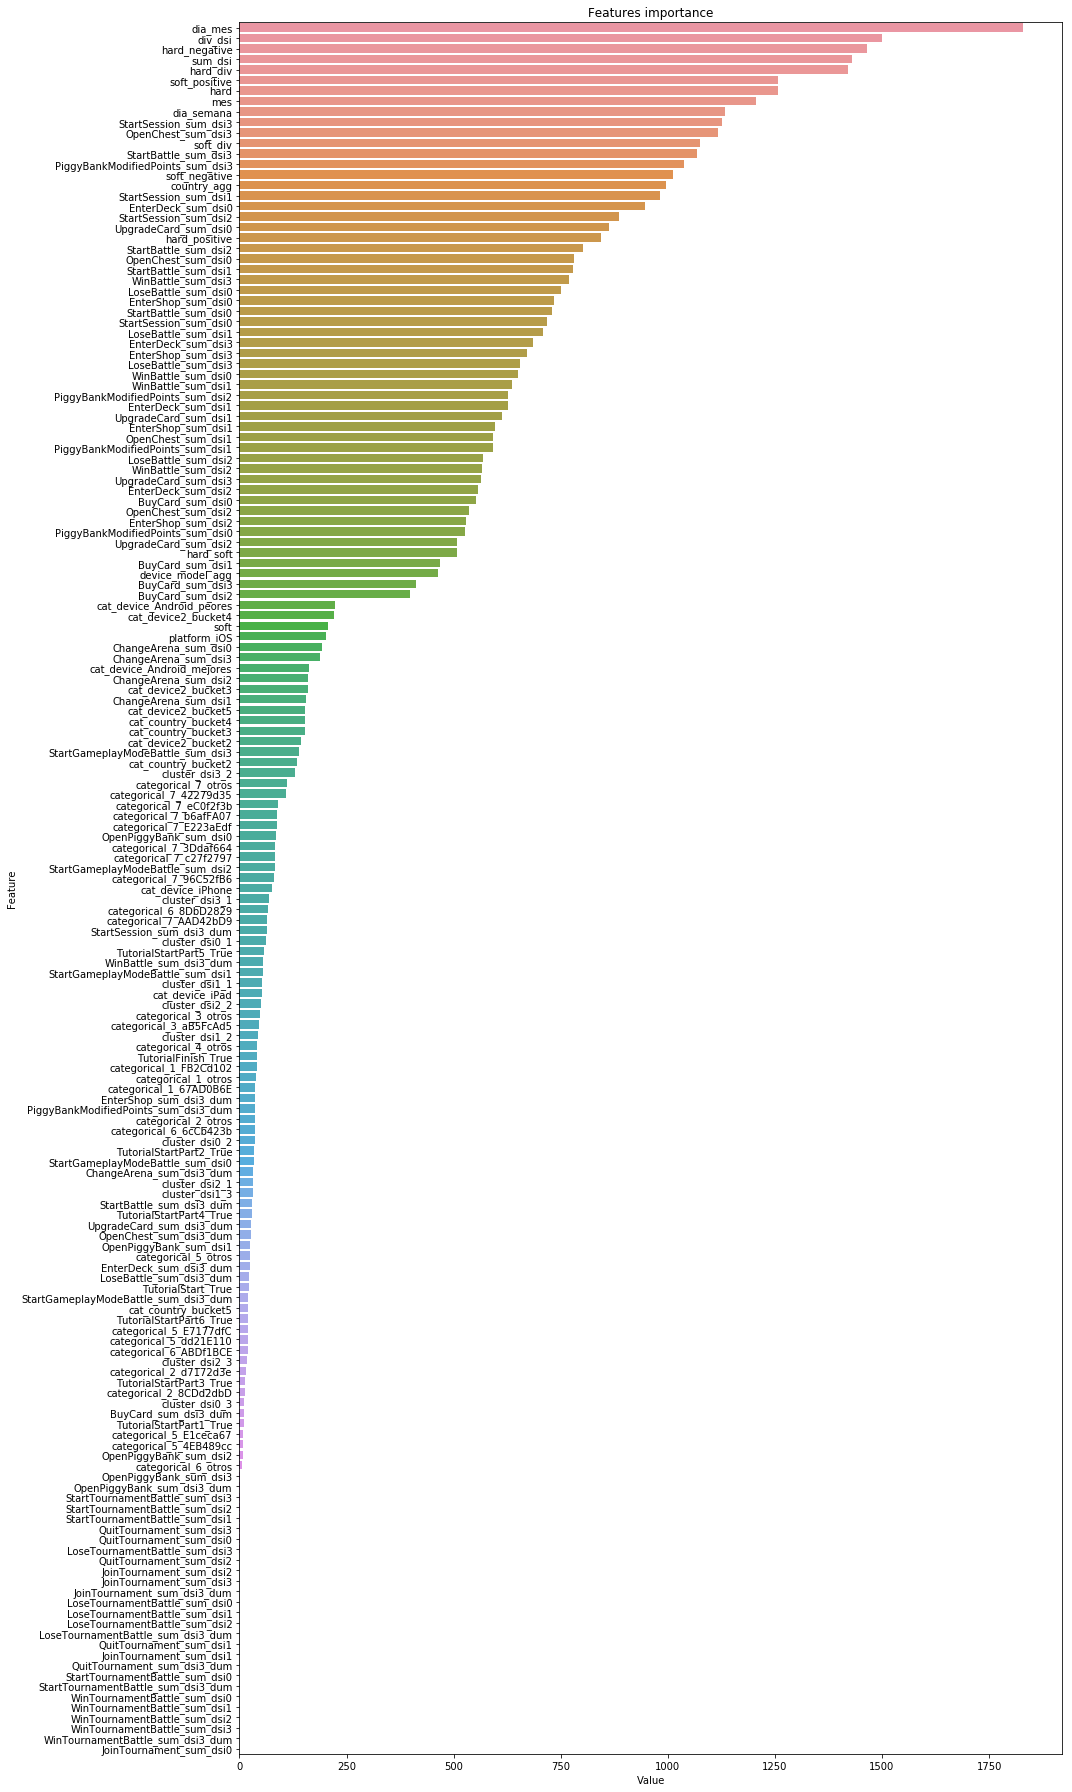

In [34]:
modelador.plot_feature_importance(tree_clf,X_train)

<h3>Guardado de modelos y creacion de submit para kaggle</h3>

In [32]:
# Predice 
probs = tree_clf.predict_proba(validation)
# Guarda resultados sobre validacion
#md.guardar_submit(probs,"resultados_sabado18_v1")

In [33]:
#Desde la funcion no corre bien el guardado de resultados. Correr este bloque.
p = pd.DataFrame(probs[:,1:])
p = p.rename(columns={0: "Label"})
p.insert(0, 'id', p.index)
p.to_csv(r'../resultados/bala_3.csv', index = False)

In [ ]:
# guardar modelo (pickle)
md.guardar_modelo(modelo,"nombreModelo")
# levantar modelo (pickle)
modelo = md.abrir_modelo("nombreModelo")

<h3>Tuneo de modelos</h3>

Tuneamos los modelos unicamente con randomSearch por una cuestion de tiempo. Lo hicimos directamente sobre el jnotebook por mayor practicidad pero codeamos funciones para tunear en model_FF.py

In [24]:
features = df.loc[:, df.columns != 'Label']
labels = df.loc[:, df.columns == 'Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

# Este diccionario sirve para comparar y setear un early stopping buscnado la mejor ROC con un set de "validacion"
# y no con los mismos test de los K-folds iterados por el Cross Validation
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [26]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
"""
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
"""

# Esta es la ultima grilla con la que probamos los distintos hyperparametros. Mucho mas reducida que las originales.
param_test = {
    "n_estimators": [800],
    "max_depth": [12,13,14],
    "colsample_bytree": [0.63],
    "min_child_weight": [0.001],
    "learning_rate":[0.12,0.13],
    'subsample': [1],
    'reg_alpha': [30, 35, 40],
    'reg_lambda': [115,120,125],
    'gamma': [5,10,15]
    }

In [27]:
n_HP_points_to_test = 30

# Hacemos un tuneo probando 90 modelos distintos (30 iteraciones por 3 Folds por combinacion)
clf = LGBMClassifier(random_state=42)
result_trainRandom = RandomizedSearchCV(
                    estimator=clf, 
                    param_distributions=param_test, 
                    n_iter=n_HP_points_to_test,
                    scoring='roc_auc',
                    cv=3,
                    refit=True,
                    random_state=42,
                    verbose=True,
                    n_jobs=-1)

result_trainRandom.fit(X_train, y_train, **fit_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 335.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 706.6min finished
/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.741733	valid's binary_logloss: 0.43252
[200]	valid's auc: 0.743908	valid's binary_logloss: 0.431289
[300]	valid's auc: 0.744674	valid's binary_logloss: 0.430834
[400]	valid's auc: 0.745089	valid's binary_logloss: 0.430595
[500]	valid's auc: 0.745357	valid's binary_logloss: 0.430438
[600]	valid's auc: 0.745548	valid's binary_logloss: 0.430316
[700]	valid's auc: 0.745741	valid's binary_logloss: 0.430202
[800]	valid's auc: 0.745927	valid's binary_logloss: 0.430087
Did not meet early stopping. Best iteration is:
[794]	valid's auc: 0.745932	valid's binary_logloss: 0.430086


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_l...
                   iid='warn', n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.63],
     

In [28]:
# Iteracion 9 LGBM
print('Best score reached: {} with params: {} '.format(result_trainRandom.best_score_, result_trainRandom.best_params_))

Best score reached: 0.7441041177232843 with params: {'subsample': 1, 'reg_lambda': 120, 'reg_alpha': 35, 'n_estimators': 800, 'min_child_weight': 0.001, 'max_depth': 12, 'learning_rate': 0.13, 'gamma': 5, 'colsample_bytree': 0.63} 


In [146]:
# Iteracion 8 LGBM
print('Best score reached: {} with params: {} '.format(result_trainRandom.best_score_, result_trainRandom.best_params_))

Best score reached: 0.7421625295384072 with params: {'subsample': 1, 'reg_lambda': 100, 'reg_alpha': 50, 'n_estimators': 900, 'min_child_weight': 0.001, 'max_depth': 15, 'learning_rate': 0.12, 'colsample_bytree': 0.63} 


In [47]:
# Iteracion 7 LGBM
print('Best score reached: {} with params: {} '.format(result_trainRandom.best_score_, result_trainRandom.best_params_))

Best score reached: 0.7415383485227477 with params: {'n_estimators': 750, 'min_child_weight': 1e-05, 'max_depth': 20, 'learning_rate': 0.15, 'colsample_bytree': 0.6} 


<h2>Analisis de componentes principales para feature importance (_dsi variables)</h2>

In [360]:
# Nos basamos en el siguiente procedimiento y lo adaptamos a nuestro caso. Este punto quedo abierto por falta de tiempo
# y porque no vimos un aporte rapido a la solucion ya que no habia un bajo grupo de features que explique la variabilidad
# Esto ultimo se ve en la proxima curva ploteada
#https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

In [278]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


names_dsiX = [col for col in df.columns if '_dsi' in col]

X = df[names_dsiX]

#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)

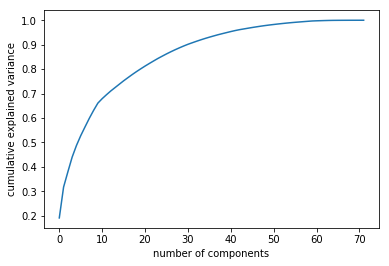

In [279]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [280]:
pca.explained_variance_ratio_

array([1.91452460e-01, 1.26041480e-01, 6.23652365e-02, 6.03157910e-02,
       4.73906471e-02, 4.02640947e-02, 3.57966626e-02, 3.51485937e-02,
       3.24420523e-02, 2.98069150e-02, 1.81514141e-02, 1.60712813e-02,
       1.53182904e-02, 1.39149990e-02, 1.38681510e-02, 1.38023523e-02,
       1.28658572e-02, 1.26960052e-02, 1.21293384e-02, 1.14648477e-02,
       1.11608962e-02, 1.06317698e-02, 1.03422882e-02, 1.01978014e-02,
       9.34157849e-03, 9.23708432e-03, 8.66912807e-03, 8.31990485e-03,
       7.79789853e-03, 7.52794521e-03, 7.00656120e-03, 6.26960808e-03,
       6.13187156e-03, 5.89074444e-03, 5.61473358e-03, 5.26593455e-03,
       4.98693148e-03, 4.89032406e-03, 4.43549962e-03, 4.36238379e-03,
       4.28000978e-03, 4.05560855e-03, 3.57388004e-03, 3.02947243e-03,
       3.00672088e-03, 2.98507792e-03, 2.74395400e-03, 2.68472351e-03,
       2.47710915e-03, 2.27974714e-03, 2.09669958e-03, 2.05972280e-03,
       1.86517171e-03, 1.82129059e-03, 1.66391453e-03, 1.53597547e-03,
      

In [283]:
names_dsiX = [col for col in df.columns if '_dsi' in col]
n_pc = 10

model = PCA(n_components=n_pc).fit(df[names_dsiX])
X_pc = model.transform(df[names_dsiX])

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = names_dsiX

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
important_features_pc = pd.DataFrame(dic.items())

In [284]:
# Features mas importantes por componente (independiente de Label)
important_features_pc

,0,1
0,PC0,PiggyBankModifiedPoints_sum_dsi0
1,PC1,OpenChest_sum_dsi3
2,PC2,StartBattle_sum_dsi1
3,PC3,StartBattle_sum_dsi0
4,PC4,StartBattle_sum_dsi1
5,PC5,PiggyBankModifiedPoints_sum_dsi3
6,PC6,PiggyBankModifiedPoints_sum_dsi3
7,PC7,PiggyBankModifiedPoints_sum_dsi2
8,PC8,PiggyBankModifiedPoints_sum_dsi2
9,PC9,UpgradeCard_sum_dsi0


<h2>Ingenieria de atributos</h2>

In [147]:
# ATRIBUTOS MAS IMPORTANTES SEGUN DISTINTOS MODELOS
"""
- install_date                         --> Se crearon las variables dia_semana y mes, y se saco la variable cruda
- platform_iOS
- StartSession_sum_dsi3                --> Dummies cortando por el mejor cuartil para todas las sum_dsiX
- OpenChest_sum_dsi3
- StartBattle_sum_dsi3
- PiggyBankModifiedPoints_sum_dsi3
- hard_positive
- hard_negative
- soft_positive
- soft_negative
- device_model (no la agg)
"""


<b>DIA DE SEMANA</b>

In [211]:
# Funciom dia de la semana
d = {'dia': [], 'dia_semana': []}
df_week_table = pd.DataFrame(data=d)

dia_sem = 0
for i in range(0,2000):
    if dia_sem==7:
        dia_sem=0
    dia_sem += 1
    df_week_table = df_week_table.append({'dia': i, 'dia_semana': dia_sem}, ignore_index=True)

df = df.merge(df_week_table, right_on="dia", left_on="install_date", how='left')  
df.drop(['dia'], axis=1, inplace = True) 


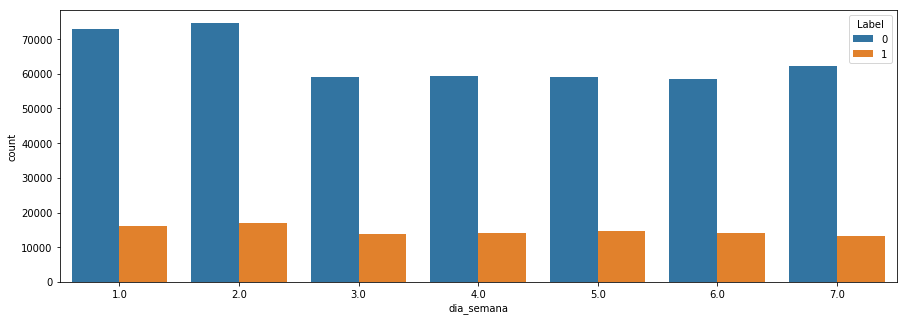

In [180]:
# Semana distribuida por dias. 1 y 2 son sabado y domingo?
s = df.merge(df_week_table, right_on="dia", left_on="install_date", how='left')

plt.subplots(figsize=(15,5))
sns.countplot(x="dia_semana", hue="Label", data=s)

<b>MES</b>

In [99]:
#Funcion mes del año
d = {'dia': [], 'mes': []}
df_mes_table = pd.DataFrame(data=d)

mes = 1
dias_mes = 0
for i in range(0,2000):
    if mes==12:
        mes=1
    if dias_mes==30:
        dias_mes=0
        mes+=1
    dias_mes += 1
    df_mes_table = df_mes_table.append({'dia': i, 'mes':mes}, ignore_index=True)

df = df.merge(df_mes_table, right_on="dia", left_on="install_date", how='left')  
df.drop(['dia'], axis=1, inplace = True) 


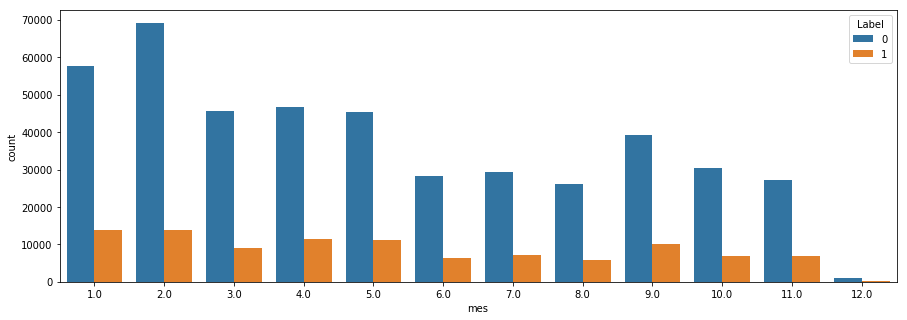

In [181]:
# Mes distribuido por la variable targe. Se nota comportamiento diferente por mes. 
#Veamoslo de manera mas fair en el siguiente plot. 
s = df.merge(df_mes_table, right_on="dia", left_on="install_date", how='left')

plt.subplots(figsize=(15,5))
sns.countplot(x="mes", hue="Label", data=s)

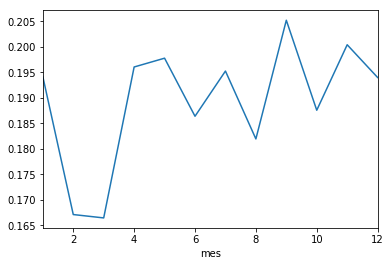

In [187]:
# probabilidad de churn por mes. Aca se nota mucho ams el cambioo de comportamiento.

a = s.groupby("mes").Label.sum()/s.groupby("mes").Label.count()
a.plot.line()

In [173]:
# En validation tenemos 2 meses? podran ser Febrero y Marzo/Enero? (28 + 31 = 59 --> 400 a 459 en validation )

mybins = range(int(validation.install_date.min()), int(validation.install_date.max()), 28)
s = pd.cut(validation.install_date, bins=mybins).dropna()

print(int(validation.install_date.max()))
s.value_counts()

400


(428, 456]    327013
(400, 428]    292411
Name: install_date, dtype: int64

In [ ]:
# Crea el dia del mes.
def crea_dia_mes(self,df):
    # Arma una tabla base con muchas semanas para 2000 dias
    d = {'dia': [], 'dia_mes': []}
    df_m_table = pd.DataFrame(data=d)

    dia_mes = 0
    for i in range(0,2000):
        if dia_mes==30:
            dia_mes=0
        dia_mes += 1
        df_m_table = df_m_table.append({'dia': i, 'dia_mes': dia_mes}, ignore_index=True)

    # Joinea con install_date para determinar que dia se intalo el juego
    df = df.merge(df_m_table, right_on="dia", left_on="install_date", how='left')  
    df.drop(['dia'], axis=1, inplace = True) 
    return df

<b>TRANSFORMACION LOGARITMICA</b>

In [1]:
# Cambiando las distribuciones no notamos impacto en las curvas de ROC. 

In [1]:
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [280]:
df[names_dsiX] = df[names_dsiX] + 1
df[names_dsiX] = df[names_dsiX].apply(np.log)

<b>TOP STANDARIZATION</b>

In [ ]:
lista_columnas_num = list(df.select_dtypes(include=['int64','float64']).columns)
df_aux = df[lista_columnas_num]
df[lista_columnas_num] = df_aux[(np.abs(stats.zscore(df_aux)) < 3).all(axis=1)] # Remove outliers
z = np.abs(stats.zscore(df[lista_columnas_num]))
print(z)

#df["abv"].apply(np.log)

<b>TENDENCIAS</b>

In [ ]:
# Habria que seguir iterandolo con algo mas robusto. Asi no aportó valor.

In [148]:
# Desde dsi0 a dsi3 con que tendencias viene X variable

In [37]:
def tendencia(df,nc):
    df.loc[df[nc+'_sum_dsi0'] + df[nc+'_sum_dsi1'] < df[nc+'_sum_dsi2'] + df[nc+'_sum_dsi3'],nc+"_tendencia"]=1
    df.loc[df[nc+'_sum_dsi0'] + df[nc+'_sum_dsi1'] > df[nc+'_sum_dsi2'] + df[nc+'_sum_dsi3'],nc+"_tendencia"]=-1
    df.loc[df[nc+'_sum_dsi0'] + df[nc+'_sum_dsi1'] == df[nc+'_sum_dsi2'] + df[nc+'_sum_dsi3'],nc+"_tendencia"]=0
    return df

In [38]:
names_dsiX = ['OpenPiggyBank',
                'StartBattle',
                'EnterShop',
                'EnterDeck',
                'StartSession',
                'WinBattle',
                'OpenChest',
                'LoseBattle']

In [39]:
for i in names_dsiX:
    df = tendencia(df,i)

<b>CORTES DUMMIES POR CUARTILES</b>

La idea es esta variable es dividir mejor a las sum_dsiX. En gral observamos que quienes tienen menor probabilidad de churn son quienes mas interactuan con el juego y que por lo tanto presentan mayores valores de sum_dsiX. Esto se observa, por ejemplo en la variable "PiggyBankModifiedPoints_sum_dsi3" y su distribucion separada por Label que aparece en el siguiente grafico.

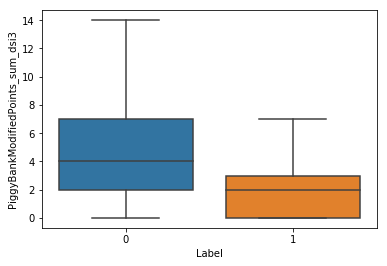

In [97]:
sns.boxplot(x="Label", y="PiggyBankModifiedPoints_sum_dsi3", data=df, showfliers = False)

Sus distribuciones se superponen. Por lo tanto, hay que elegir un punto de corte. Podria ser a partir del cuartil 3 de label 1 o a partir del cuartil 1 de label 0. La pregunta que surge inmediatamente es, cual es mejor? existe una diferencia entre cortar por uno o por otro?

Para responder la pregunta anterior se desarrollo la funcion que se presenta a continuacion. En ella, se evalua cuantos 0s vs 1s (valores de label) se pierden o se ganan por elegir un corte u otro.

In [234]:
def que_es_mejor(df,nombreCol):
    
    #Cuantos ceros sacrifico
    cant_0s_Mas1s = df[(df[nombreCol] < df[df.Label==1][nombreCol].quantile(0.75)) 
                       & (df.Label == 0)][nombreCol].count()
    
    cant_0s_Menos1s = df[(df[nombreCol] < df[df.Label==0][nombreCol].quantile(0.25)) 
                       & (df.Label == 0)][nombreCol].count()
    
    ceros_a_favor = (cant_0s_Mas1s - cant_0s_Menos1s)
    
    #Cuantos unos sacrifico
    cant_1s_Mas0s = df[(df[nombreCol] < df[df.Label==1][nombreCol].quantile(0.75)) 
                       & (df.Label == 1)][nombreCol].count()
    
    cant_1s_Menos0s = df[(df[nombreCol] < df[df.Label==0][nombreCol].quantile(0.25)) 
                       & (df.Label == 1)][nombreCol].count()
    
    unos_a_favor = cant_1s_Mas0s - cant_1s_Menos0s
    

    print(nombreCol)
    
    if ceros_a_favor != 0 or unos_a_favor != 0:
        print("Cantidad de 0s ganados: ",str(ceros_a_favor))
        print("Cantidad de 1s ganados: ",str(unos_a_favor))
    if ceros_a_favor == 0 and unos_a_favor == 0:
        print("Mean de 0s ganados: ",str(df[df.Label==0][nombreCol].mean()))
        print("Mean de 1s ganados: ",str(df[df.Label==1][nombreCol].mean()))
    print()

La ejecutamos para el ejemplo de "PiggyBankModifiedPoints_sum_dsi3" y vemos que si cortamos a favor de 0 ganamos mas 0s que si cortamos a favor de 1s para los valores de Label. Como el costo de hacer churn o no, no fue definido, para este caso, que el modelo prediga que una persona realizara churn vs una que no lo realizara es el mismo, por lo que las cantidades son directamente comparables.

In [98]:
que_es_mejor(df,"PiggyBankModifiedPoints_sum_dsi3")

Cantidad de 0s ganados: 32409
Cantidad de 1s ganados: 10257


Sirve de algo esto? el resultado lo vemos en el grafico de feature importance a continuacion, donde se observa que priorizar 0s hace que el corte de la nueva variable dummie sea casi tan importante que la variable original, mientras que la variable que prioriza los 1s es mucho menos importante. (ver imagen feature importance)

In [ ]:
df["prioridad_1s"] = 0
df.loc[(df.PiggyBankModifiedPoints_sum_dsi3 < df[df.Label==1].PiggyBankModifiedPoints_sum_dsi3.quantile(0.75)),"prioridad_1s"]=1

df["prioridad_0s"] = 0
df.loc[(df.PiggyBankModifiedPoints_sum_dsi3 < df[df.Label==0].PiggyBankModifiedPoints_sum_dsi3.quantile(0.25)),"prioridad_0s"]=1

In [231]:
def dummies_for_dsi(df):
    names_dsiX = [col for col in df.columns if '_dsi' in col]
    for i in names_dsiX:
        que_es_mejor(df,i)
        

In [235]:
dummies_for_dsi(df)

BuyCard_sum_dsi0
Cantidad de 0s ganados:  293633
Cantidad de 1s ganados:  72984

BuyCard_sum_dsi1
Mean de 0s ganados:  1.9207615715823465
Mean de 1s ganados:  1.3769764620237805

BuyCard_sum_dsi2
Mean de 0s ganados:  1.5769891460351633
Mean de 1s ganados:  1.0100946372239747

BuyCard_sum_dsi3
Mean de 0s ganados:  1.5146528525296017
Mean de 1s ganados:  0.8114049987867022

ChangeArena_sum_dsi0
Mean de 0s ganados:  1.0339612486544671
Mean de 1s ganados:  0.9181169619024508

ChangeArena_sum_dsi1
Mean de 0s ganados:  0.35698780050233225
Mean de 1s ganados:  0.2203154574132492

ChangeArena_sum_dsi2
Mean de 0s ganados:  0.27274174739863655
Mean de 1s ganados:  0.13891773841300656

ChangeArena_sum_dsi3
Mean de 0s ganados:  0.20712683889486905
Mean de 1s ganados:  0.07584566852705654

EnterDeck_sum_dsi0
Cantidad de 0s ganados:  176794
Cantidad de 1s ganados:  43220

EnterDeck_sum_dsi1
Cantidad de 0s ganados:  253498
Cantidad de 1s ganados:  73683

EnterDeck_sum_dsi2
Cantidad de 0s ganados:  23

<b>CONCLUSION</b>

Se probo cambiar el Q3 del label 1 por el Q2 del label 1 y en todos los casos parece siempre convenir cortar por el Q1 del label 0. Existen casos en los que el Q1 del label 0 es igual al Q2 y Q3 de label 1. En ese caso se definirá el corte por diferencia de medias.

<b>CLUSTERING DSIX</b>

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import preprocessing

In [28]:
names_dsiX = [col for col in df.columns if '_dsi3' in col] 

# normalizar datos
normalized_df = preprocessing.normalize(df[names_dsiX])

X = np.array(normalized_df)
X.shape

(5489453, 18)

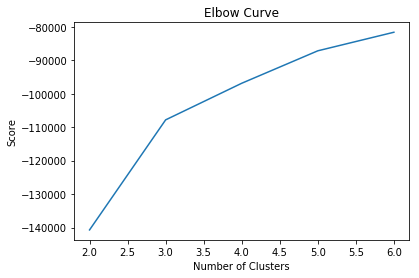

In [24]:
Nc= range (2,7)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [29]:
#Entrenar modelo usando el k optimo del paso anterior
kmeans = KMeans(n_clusters=3).fit(X)
#Clasificacion
labels = kmeans.predict(X)
#Creamos variable y vemos media de churn por grupo
df['cluster']=labels
df.groupby('cluster')['Label'].mean()

cluster
0    0.126078
1    0.351899
2    0.177509
Name: Label, dtype: float64

In [ ]:
#dsi 3 (3 clusters)
#dsi 2 (4 clusters)
#dsi 1 (4 clusters)
#dsi 0 (4 clusters)

Encontramos que para cada dsiX hay cortes por clusters que diferencian en gran medida la probabilidad de churn. Por esto, vamos a entrena en total 4 modelos de kmeans.

In [45]:
# Entrenamiento de modelos K-means

names_dsiX = [col for col in df.columns if '_dsi3' in col] 

# normalizar datos
normalized_df = preprocessing.normalize(df[names_dsiX])
X = np.array(normalized_df)
X.shape

# Se entrena el modelo
kmeans = KMeans(n_clusters=3).fit(X)

In [43]:
# Se guarda el pickle que va a ser levantado luego para scorear por transformer_FF.py
with open('../pickles/kmeans_dsi3.pkl', 'wb') as handle:
    pickle.dump(kmeans, handle, pickle.HIGHEST_PROTOCOL)

<b>VARIABLES DE MONEDA</b>

In [164]:
df["hard"] = (df.hard_positive - df.hard_negative)

In [165]:
df["soft"] = (df.soft_positive - df.soft_negative)

In [166]:
df["hard_soft"] = (df.hard_positive + df.soft_positive - df.hard_negative - df.soft_negative)

In [39]:
df["hard_div"] = (df.hard_negative / df.hard_positive)
df.loc[df.hard_negative / df.hard_positive == float('inf'),"hard_div"]=1
df["hard_div"].fillna(0, inplace=True)

In [40]:
df["soft_div"] = (df.soft_negative / df.soft_positive)
df.loc[df.soft_negative / df.soft_positive == float('inf'),"soft_div"]=1
df["soft_div"].fillna(0, inplace=True)

<b>VARIABLES SUMA Y DIVISION</b>

In [16]:
df["sum_dsi"] = (df.StartSession_sum_dsi3 + df.StartSession_sum_dsi2 + df.StartSession_sum_dsi1 + df.StartSession_sum_dsi0+
                 df.StartBattle_sum_dsi3 + df.StartBattle_sum_dsi2 + df.StartBattle_sum_dsi1 + df.StartBattle_sum_dsi0+
                 df.WinBattle_sum_dsi3 + df.WinBattle_sum_dsi2 + df.WinBattle_sum_dsi1 + df.WinBattle_sum_dsi0+
                 df.EnterDeck_sum_dsi3 + df.EnterDeck_sum_dsi2 + df.EnterDeck_sum_dsi1 + df.EnterDeck_sum_dsi0+
                 df.OpenChest_sum_dsi3 + df.OpenChest_sum_dsi2 + df.OpenChest_sum_dsi1 + df.OpenChest_sum_dsi0)


In [17]:
df["div_dsi"] = ( (df.StartSession_sum_dsi3 + df.StartBattle_sum_dsi3 + df.WinBattle_sum_dsi3 + df.EnterDeck_sum_dsi3 +
                  df.OpenChest_sum_dsi3) / 
                  (df.StartSession_sum_dsi3 + df.StartSession_sum_dsi2 + 
                  df.StartBattle_sum_dsi3 + df.StartBattle_sum_dsi2 +
                  df.WinBattle_sum_dsi3 + df.WinBattle_sum_dsi2 + 
                  df.EnterDeck_sum_dsi3 + df.EnterDeck_sum_dsi2 +
                  df.OpenChest_sum_dsi3 + df.OpenChest_sum_dsi2)   )